# Analysis using raw functions (not the MNE package)


## imports

In [27]:
import sys

# adds the library path
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce, partial
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
from functional import seq
from scipy import signal
from itertools import combinations 
import mne

from importlib import reload

from nfme.utils.jupyter import display_video
from nfme.config import config
from nfme.utils import data_loading as data
from nfme.features import bandpower

%matplotlib inline

In [2]:
if [int(i) for i in mne.__version__.split('.')] < [0, 20, 0]:
    print('should be at least 0.20.0')
    stop # this is the best hack, it clearly does what it is supposed to do

In [3]:
from pprint import PrettyPrinter

PrettyPrinter(indent=4).pprint(config)

{   'bandpass_filter': [0.5, 30],
    'bandpower_window_width': '1s',
    'bands': {   'alpha': [8, 12],
                 'beta': [12, 40],
                 'delta': [0, 4],
                 'gamma': [40, 100],
                 'theta': [4, 8]},
    'columns_to_remove': ['TRIGGER', 'X1', 'X2', 'X3'],
    'default_signal_crop': slice(3000, -3000, None),
    'paths': {   'base': '/home/sam/proj/epfl/eeg-meditation-project/nfme/data/AlphaTheta',
                 'channels_file': 'channelsList.txt',
                 'features': '/home/sam/proj/epfl/eeg-meditation-project/nfme/data/features',
                 'subjects': {   'adelie': {   'prefix': '/adelie-AlphaTheta',
                                               'recordings': {   'baseline': [   '20200304-151358',
                                                                                 '20200311-104132'],
                                                                 'meditation': [   '20200304-152058',
                       

## data loading and bandpower computation

In [7]:
signal_data_sam = data.load_combined_data(subject='sam')
signal_data_adelie = data.load_combined_data(subject='adelie')

In [33]:
layout = data.load_layout()

Opening raw data file /home/sam/proj/epfl/eeg-meditation-project/nfme/data/AlphaTheta/sam-AlphaTheta/offline/fif/20200304-144100-raw.fif...
Isotrak not found
    Range : 0 ... 38051 =      0.000 ...   126.837 secs
Ready.
Reading 0 ... 38051  =      0.000 ...   126.837 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
2 events found
Event IDs: [15 16]
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


In [18]:
reload(bandpower)

dflt_values = {
    'bands': config['bands'],
    'window_size': config['bandpower_window_width'],
    'sampling_frequency': config['sampling_frequency'],
} 

bandpowers_sam = bandpower.compute_bandpowers(signal_data_sam, 
                                              subject='sam',
                                              **dflt_values)

bandpowers_adelie = bandpower.compute_bandpowers(signal_data_adelie, 
                                                 subject='adelie',
                                                 **dflt_values)


In total 400 features / bandpowers will have to be computed /loaded. This might take a while...
delta, 0, baseline done.................. currently: delta, 0, baseline

delta, 1, baseline done.................. currently: delta, 1, baseline

delta, 0, meditation done................ currently: delta, 0, meditation

delta, 1, meditation donexxxxxxxxxxxxxxxx currently: delta, 1, meditation

sam done
In total 400 features / bandpowers will have to be computed /loaded. This might take a while...
delta, 0, baseline done.................. currently: delta, 0, baseline

delta, 1, baseline done.................. currently: delta, 1, baseline

delta, 0, meditation done................ currently: delta, 0, meditation

delta, 1, meditation donexxxxxxxxxxxxxxxx currently: delta, 1, meditation

adelie done


In [23]:
reload(bandpower)
bandpowers_sam_30s = bandpower.compute_bandpowers(signal_data_sam, 
                                                  subject='sam',
                                                  **{**dflt_values, 'window_size': '30s'})

bandpowers_adelie_30s = bandpower.compute_bandpowers(signal_data_adelie, 
                                                     subject='adelie',
                                                     **{**dflt_values, 'window_size': '30s'})

In total 400 features / bandpowers will have to be computed / loaded. This might take a while...
computing bandpower: xxxxx............... currently: delta, 0, baseline
delta, 0, baseline done
computing bandpower: xxxxxxxxxx.......... currently: delta, 1, baseline
delta, 1, baseline done
computing bandpower: xxxxxxxxxxxxxxx..... currently: delta, 0, meditation
delta, 0, meditation done
computing bandpower: xxxxxxxxxxxxxxxxxxxx currently: delta, 1, meditation
delta, 1, meditation done
done with bandpower computation for subject sam
In total 400 features / bandpowers will have to be computed / loaded. This might take a while...
computing bandpower: xxxxx............... currently: delta, 0, baseline
delta, 0, baseline done
computing bandpower: xxxxxxxxxx.......... currently: delta, 1, baseline
delta, 1, baseline done
computing bandpower: xxxxxxxxxxxxxxx..... currently: delta, 0, meditation
delta, 0, meditation done
computing bandpower: xxxxxxxxxxxxxxxxxxxx currently: delta, 1, meditation


## audio

In [25]:
#alpha_over_theta_meditation = bandpowers_sam_30s['meditation'][0]['alpha'] / bandpowers_sam_30s['meditation'][0]['theta']
#alpha_over_theta_baseline   = bandpowers_sam_30s['baseline'][0]['alpha']   / bandpowers_sam_30s['baseline'][0]['theta']

In [28]:
def _ratios_for_recordings_(recording, numerator, denominator):
    return recording[numerator] / recording[denominator]

_alpha_theta_ratio_fn_ = partial(_ratios_for_recordings_, numerator='alpha', denominator='theta')
    
alpha_theta_ratios = {recording_type: [_alpha_theta_ratio_fn_(rec) for rec in recordings.values()] for recording_type, recordings in bandpowers_sam_30s.items()}

I just pick one of the frontal electrodes...

In [29]:
electrode_of_interest = 'Fp1'

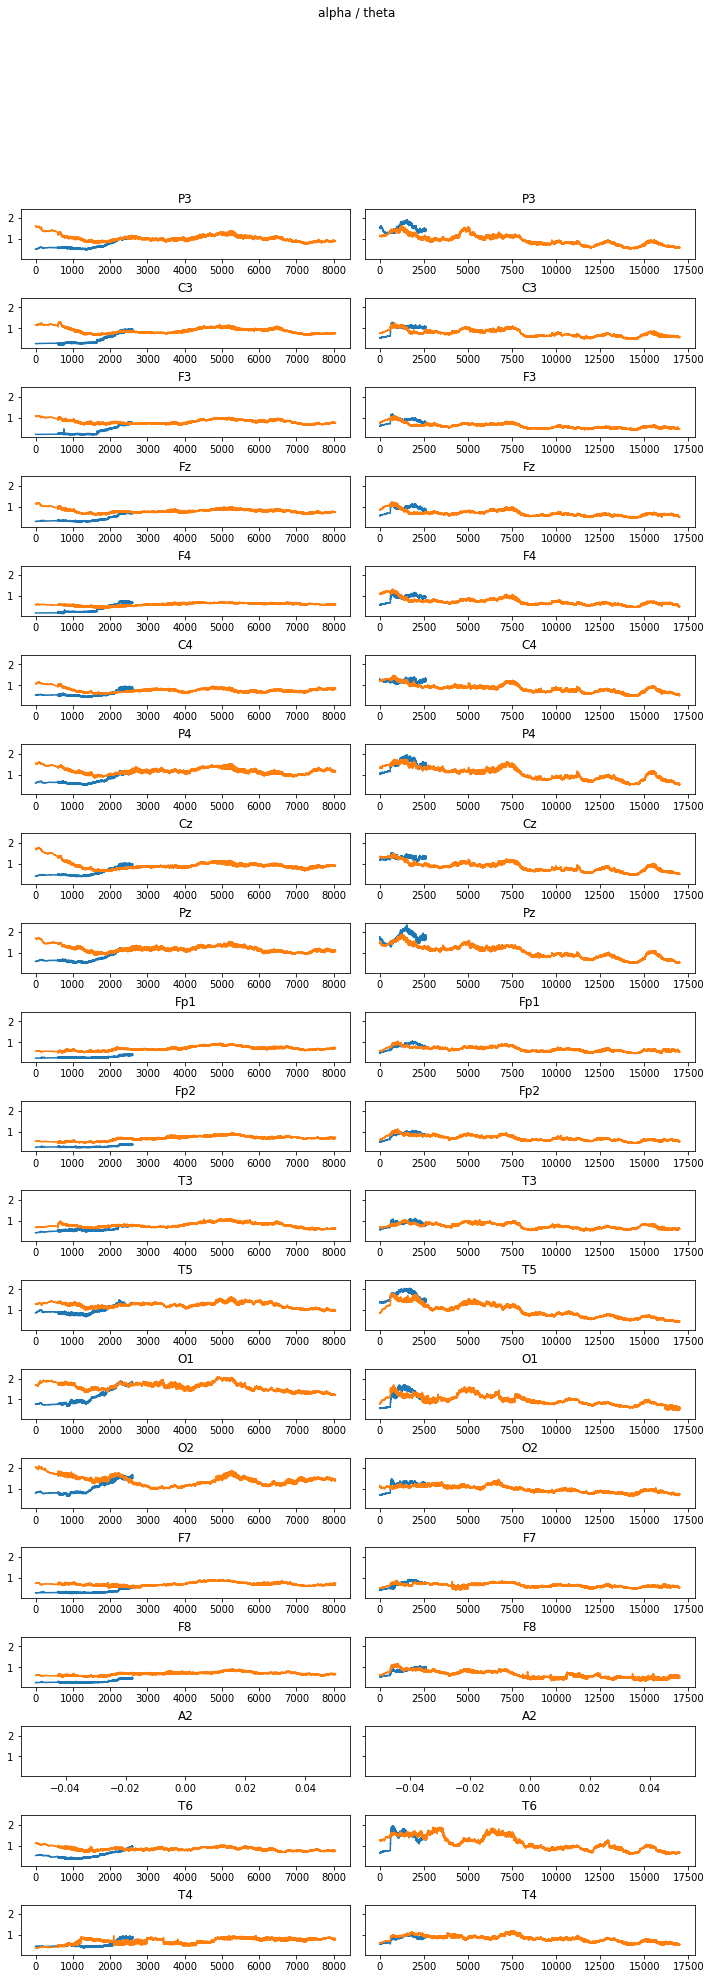

In [30]:
# just cuttong some stuff away at the beginning and end to have a cleaner signal
#electrodes_of_interest = ['Fp1', 'T3', 'O1', 'Cz']
electrodes_of_interest = list(alpha_theta_ratios['baseline'][0].columns)
n_recordings = len(alpha_theta_ratios['baseline'])

fig, axs = plt.subplots(ncols=n_recordings, 
                        nrows=len(electrodes_of_interest),
                        figsize=(5 * len(alpha_theta_ratios['baseline']), len(electrodes_of_interest) * 1.4), 
                        sharey=True)


for recording_type, recording in alpha_theta_ratios.items():
    for recording_idx in range(n_recordings):
        for idx, electrode_of_interest in enumerate(electrodes_of_interest):
            axs[idx][recording_idx].plot(recording[recording_idx].iloc[3000: -3000: 10].loc[:, electrode_of_interest].reset_index(drop=True),
                                         label=recording_type)
            
            axs[idx][recording_idx].set_title(electrode_of_interest)
        
        
                                     
        #_t=.loc[alpha_over_theta_baseline.index[3000:-3000:10], electrode_of_interest]
        #axs[idx].plot(_t.index, _t.values, label="baseline")
        ##sns.lineplot(x=_t.index, y=_t.values, ax=axs[idx], label="baseline")
        #_t=alpha_over_theta_meditation.loc[alpha_over_theta_meditation.index[3000:-3000:10], electrode_of_interest]
        #axs[idx].plot(_t.index, _t.values, label="meditation")
        ##sns.lineplot(x=_t.index, y=_t.values, ax=axs[idx], label="meditation")
        #axs[idx].set_title(electrode_of_interest)

fig.suptitle('alpha / theta')
#axs[-1].legend()
fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [175]:
_t=alpha_over_theta_meditation.loc[alpha_over_theta_meditation.index[3000:-3000:10], electrode_of_interest]

In [176]:
_t.index

TimedeltaIndex(['00:00:19.981125', '00:00:20.010008', '00:00:20.041088',
                '00:00:20.100157', '00:00:20.129708', '00:00:20.161087',
                '00:00:20.190553', '00:00:20.220791', '00:00:20.250103',
                '00:00:20.280194',
                ...
                '00:04:47.852557', '00:04:47.883984', '00:04:47.913559',
                '00:04:47.944060', '00:04:48.004220', '00:04:48.033319',
                '00:04:48.062938', '00:04:48.093050', '00:04:48.123598',
                '00:04:48.152757'],
               dtype='timedelta64[ns]', length=8046, freq=None)

In [ ]:
# normalising it using the baseline to be between 0 and 1


In [99]:
alpha_over_theta_meditation.loc[alpha_over_theta_meditation.notna().any(axis=1), :].describe()

,P3,C3,F3,Fz,F4,C4,P4,Cz,Pz,Fp1,Fp2,T3,T5,O1,O2,F7,F8,A2,T6,T4
count,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000,86304.000000
mean,1.064283,0.940577,0.801473,0.784472,0.593392,0.801044,1.226955,0.982395,1.266063,0.659404,0.630638,0.768429,1.252388,1.600407,1.535105,0.689991,0.650522,0.958470,0.853018,0.706216
std,0.339313,0.279245,0.131377,0.114755,0.061345,0.152124,0.166271,0.349187,0.240284,0.101149,0.107289,0.121519,0.190090,0.195649,0.402555,0.081881,0.075583,0.132987,0.103179,0.135136
min,0.742374,0.653458,0.613180,0.574680,0.200383,0.572790,0.753251,0.607069,0.922986,0.260702,0.222638,0.396915,0.869381,1.046020,1.009512,0.373287,0.259167,0.287108,0.460916,0.319126
25%,0.943547,0.790402,0.715032,0.711693,0.557782,0.697330,1.113336,0.841022,1.130054,0.576946,0.529291,0.673649,1.150102,1.446518,1.300909,0.644456,0.581591,0.860955,0.781045,0.592375
50%,1.007026,0.848723,0.766752,0.771770,0.600834,0.780213,1.208322,0.913783,1.230836,0.664869,0.649892,0.745405,1.249094,1.598874,1.497136,0.675256,0.659253,0.946806,0.836538,0.743094
75%,1.090173,0.982589,0.857352,0.822765,0.639402,0.847059,1.314576,0.982617,1.330339,0.719306,0.710677,0.856863,1.324166,1.759124,1.639731,0.727824,0.707268,1.054634,0.910089,0.815816
max,13.454583,2.584015,2.000568,1.652026,0.864628,1.839969,2.289312,7.304622,4.142950,0.918212,0.854734,1.295215,5.487144,2.097352,8.066276,1.192306,0.833778,1.277046,1.639404,1.023556


In [88]:
alpha_over_theta_meditation.loc[:, 'Fp1'].describe()

count    86304.000000
mean         0.659404
std          0.101149
min          0.260702
25%          0.576946
50%          0.664869
75%          0.719306
max          0.918212
Name: Fp1, dtype: float64

# Video

In [34]:
from nfme.utils import video
normalised_pos = video.normalise_layout_pos(layout)

#video_file_names = [gen_topomap_video(bp2['sam']['meditation'][band], normalised_pos, f"{band}-{subject}-{recording_type}-{recording_id}") for b in cfg['bands'].keys()]

In [42]:
reload(video)
#frames = video.gen_topomap_frames_all_bands(bandpowers_sam_30s['baseline'][0], normalised_pos, fraction_to_plot=0.01)

video.save_frames(frames, 'baseline_all_bands_30s.mp4')

In [43]:
display_video('baseline_all_bands_30s.mp4')

In [ ]:
stop

In [350]:
def gen_topomap_video_all(data, normalised_pos, title, fraction_to_plot= 0.01):
    n_plots = np.int(data.shape[0] * fraction_to_plot) # // cfg['sampling_frequency']
    bandpower_over_time_index = data.index
    times_index_to_plot = np.linspace(start=0, stop=bandpower_over_time_index.shape[0] - 1, num=n_plots, dtype=np.int)
    
    frames = gen_topomap_frames(data=data,
                                times_index_to_plot=times_index_to_plot,
                                pos=normalised_pos,
                                title=title)

    movie_file_name = f"{title}.mp4"
    save_frames(frames, movie_file_name)
    return movie_file_name

In [ ]:
stop

In [ ]:
meditation_bandpower = get_bandpower_for_electrode(meditation_pd, electrode=electrode_of_interest, config=cfg)
baseline_bandpower   = get_bandpower_for_electrode(baseline_pd, electrode=electrode_of_interest, config=cfg)

In [ ]:
# for each of the evoked chanels
meditation_bandpower = pd.DataFrame(meditation_bandpower)

In [ ]:
bandpower_adelie = {
    'baseline': get_bandpower_for_electrode(baseline_adelie_pd, electrode=electrode_of_interest, config=cfg),
    'meditation': get_bandpower_for_electrode(meditation_adelie_pd, electrode=electrode_of_interest, config=cfg)
}

In [ ]:
plot_raw_signal(baseline_pd);

In [ ]:
plot_raw_signal(meditation_pd);

In [ ]:
plot_bandpowers(baseline_bandpower, electrode=electrode_of_interest);

In [ ]:
plot_bandpowers(meditation_bandpower, electrode=electrode_of_interest);

In [ ]:
aggregated_power_adelie = aggregate_bandpower(baseline=bandpower_adelie['baseline'], signal=bandpower_adelie['meditation'])
aggregated_power_adelie

In [ ]:
aggregated_power_sam = aggregate_bandpower(baseline=baseline_bandpower, signal=meditation_bandpower)
aggregated_power_sam

## spectrogram videos

In [ ]:
fif_meditation = load_raw_mne_from_fif('meditation', subject='sam', config=cfg)

In [ ]:
meditation_csd = mne.preprocessing.compute_current_source_density(fif_meditation)

In [ ]:
meditation_csd.plot(scalings='auto')
meditation_csd.plot_psd()

In [ ]:
def raw_to_epochs(raw, events, sampling_frequency, weird_epoch_offset=100):
    return mne.Epochs(raw=raw, events=events, tmax=events[-1, 0] * 1 / sampling_frequency - weird_epoch_offset).average()

In [ ]:
signals_meditation, events_meditation = load_raw_mne_from_fif('meditation', subject='sam', config=cfg)
signals_baseline, events_baseline = load_raw_mne_from_fif('baseline', subject='sam', config=cfg)

In [ ]:
signals_baseline.plot_sensors(show_names=True)

In [ ]:
epochs_meditation = raw_to_epochs(raw=signals_meditation, events=events_meditation, sampling_frequency=cfg['sampling_frequency'])
epochs_meditation.plot_topomap()

In [ ]:
epochs_baseline = raw_to_epochs(raw=signals_baseline, events=events_baseline, sampling_frequency=cfg['sampling_frequency'])
epochs_baseline.plot_topomap()

In [ ]:
epochs_baseline.info

In [ ]:
def plot_topomap_over_time(title, epochs, events, sampling_frequency, n_plots=64, weird_epoch_offset=100):
    last_frame_in_seconds = np.floor(events[-1, 0] * 1 / sampling_frequency - weird_epoch_offset)
    all_times = np.linspace(0, last_frame_in_seconds, n_plots)
    return epochs.plot_topomap(all_times, ch_type='eeg', time_unit='s', ncols=8, nrows='auto', title=title)

In [ ]:
plot_topomap_over_time(epochs=epochs_baseline,
                       events=events_baseline,
                       sampling_frequency=cfg['sampling_frequency'],
                       title='baseline')

In [ ]:
plot_topomap_over_time(epochs=epochs_meditation,
                       events=events_meditation,
                       sampling_frequency=cfg['sampling_frequency'],
                       title='meditation')

In [ ]:
def epochs_to_animation(file_name, epochs, events, sampling_frequency, n_frames, weird_offset=100):
    to_file_parameters = {'show': False, 'blit': False}

    #fig, anim = epochs.animate_topomap(ch_type='eeg', times=np.arange(0, 40 events[-1, 0] * 1 / cfg['sampling_frequency'] - 10, 0.5),  butterfly=True)
    fig, anim = epochs.animate_topomap(ch_type='eeg', 
                                       times=np.linspace(0, events[-1, 0] * 1 / sampling_frequency - weird_offset, n_frames),
                                       butterfly=True, 
                                       **to_file_parameters)
    anim.save(f"{file_name}.mp4")

In [ ]:
epochs_to_animation('baseline', 
                    epochs=epochs_baseline,
                    events=events_baseline,
                    sampling_frequency=cfg['sampling_frequency'],
                    n_frames=10)

In [ ]:
epochs_to_animation('meditation', 
                    epochs=epochs_meditation,
                    events=events_meditation,
                    sampling_frequency=cfg['sampling_frequency'],
                    n_frames=10)

In [ ]:
stop

In [ ]:
reject = dict(eeg=180e-6, eog=150e-6)
event_id, tmin, tmax = {'left/auditory': 1}, -0.2, 0.5
events = mne.read_events(event_fname)
epochs_params = dict(events=events, event_id=event_id, tmin=tmin, tmax=tmax,
                     reject=reject)

evoked_no_ref = mne.Epochs(raw, **epochs_params).average()

title = 'EEG Original reference'
evoked_no_ref.plot(titles=dict(eeg=title), time_unit='s')
evoked_no_ref.plot_topomap(times=[0.1], size=3., title=title, time_unit='s')

## 

## 

# Graveyard, not interesting below here

In [ ]:
sampling_rate = 300
window_size = 4 * sampling_rate # in seconds

plt.figure(figsize=(24, 10))
for c in [c for c in signals_pd.columns if c not in ['TRIGGER', 'X1', 'X2', 'X3', 'A2']]:
    freqs, psd = signal.welch(signals_pd.loc[:, c], sampling_rate, nperseg=window_size)

    plt.plot(freqs, psd, label=c)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    #plt.ylim([0, psd.max() * 1.1])
    plt.title("Welch's periodogram")
    #plt.xlim([0, freqs.max()])
    plt.xlim([0, 20])
    sns.despine()
    
plt.legend();

In [ ]:
# for a window size of... compute the power and compare it over time



bandpower(signals_pd.loc[:, 'T5'], 300., cfg['bands']['theta'])

In [ ]:
signals = baseline['signals']
fig, axs = plt.subplots(nrows=signals.shape[1], figsize=(40, 1.4 * signals.shape[1]))
for channel in range(signals.shape[1]):
    sns.lineplot(data=signals[::10, channel], ax=axs[channel], )
    axs[channel].set_ylabel(baseline['ch_names'][channel])
    
axs[-1].set_xlabel('time [ms]');

In [ ]:
38052/60